In [1]:
#Code to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Install required libraries
!pip install yfinance

### **Required Imports**

In [3]:
#Required Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import yfinance as yf
import time
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import deque
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers import Layer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score

### **Data Collection and Preprocessing**

In [4]:
# Code to download the stock data
stock_symbol = 'MARUTI.NS'
stock_data = yf.download(stock_symbol, period="5y")
df = pd.DataFrame(stock_data)
df.reset_index(inplace = True)

print("Size of the data: ",df.shape[0])

[*********************100%%**********************]  1 of 1 completed
Size of the data:  1236


In [5]:
#Compute the mid value for the stock, that would be considered as that day's price
df['Mid'] = (df['Low']+df['High'])/2.0

In [6]:
#Display the data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid
0,2018-12-11,7240.500000,7346.000000,7215.549805,7305.350098,6983.258789,843166,7280.774902
1,2018-12-12,7340.000000,7507.299805,7295.000000,7471.850098,7142.417480,643037,7401.149902
2,2018-12-13,7477.500000,7700.000000,7477.500000,7670.500000,7332.309570,881204,7588.750000
3,2018-12-14,7684.000000,7690.000000,7545.950195,7662.149902,7324.327148,676653,7617.975098
4,2018-12-17,7691.899902,7800.000000,7650.000000,7734.049805,7393.057129,712296,7725.000000


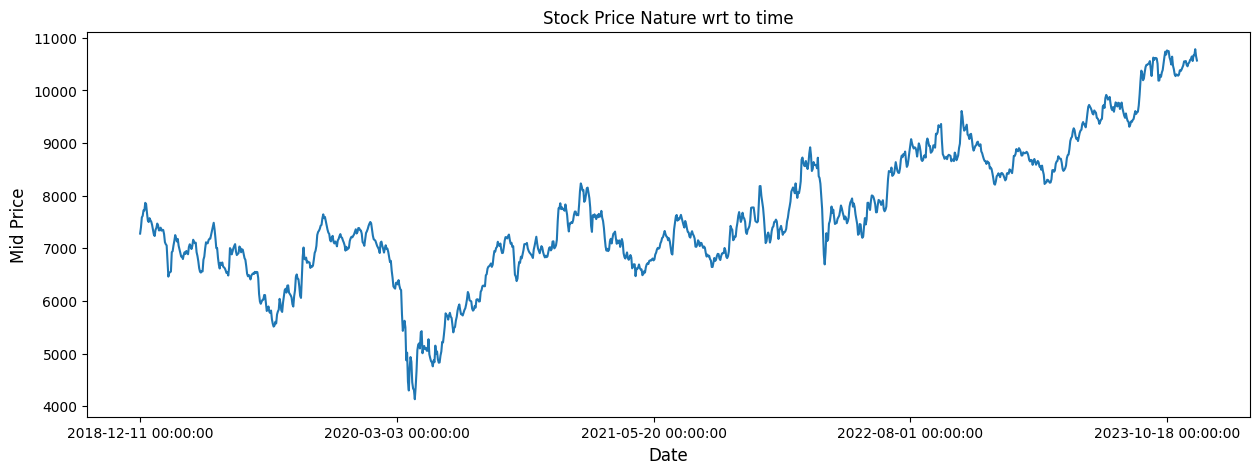

In [7]:
#Visualize the nature of price through out the time period
plt.figure(figsize = (15,5))
plt.plot(range(df.shape[0]),(df['Mid']))
plt.xticks(range(0,df.shape[0],300),df['Date'].loc[::300],rotation=0)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Mid Price',fontsize=12)
plt.title("Stock Price Nature wrt to time")
plt.show()

In [8]:
#Define the Parameters
SEQ_LEN = 60  #Window Size
FUTURE_PERIOD_PREDICT = 1
RATIO_TO_PREDICT = "Mid"

In [9]:
#Function to classify whether in future the price will increase or decrease
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [10]:
#Assign the target column accordingly
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [11]:
#Display the data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid,future,target
0,2018-12-11,7240.500000,7346.000000,7215.549805,7305.350098,6983.258789,843166,7280.774902,7401.149902,1
1,2018-12-12,7340.000000,7507.299805,7295.000000,7471.850098,7142.417480,643037,7401.149902,7588.750000,1
2,2018-12-13,7477.500000,7700.000000,7477.500000,7670.500000,7332.309570,881204,7588.750000,7617.975098,1
3,2018-12-14,7684.000000,7690.000000,7545.950195,7662.149902,7324.327148,676653,7617.975098,7725.000000,1
4,2018-12-17,7691.899902,7800.000000,7650.000000,7734.049805,7393.057129,712296,7725.000000,7720.000000,0


#### **Splitting Data into Train, Valid and Test Data**

In [12]:
#Splitting data into train, valid and test data
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10%
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # get the last 20%

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]
train_df = df[(df.index < last_20pct)]  # now the train_df is all the data up to the last 20%

In [13]:
#Drop unnecessary columns
train_df.drop(columns=["Date",'future', 'Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], inplace=True)
validation_df.drop(columns=["Date", 'future','Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], inplace=True)
test_df.drop(columns=["Date",'future', 'Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], inplace=True)

In [14]:
#Display train data
train_df.head()

,Mid,target
0,7280.774902,1
1,7401.149902,1
2,7588.750000,1
3,7617.975098,1
4,7725.000000,0


In [15]:
#Convert to values and then reshape to a proper format
train_data = train_df[RATIO_TO_PREDICT].values
train_label = train_df['target'].values
valid_data = validation_df[RATIO_TO_PREDICT].values
valid_label = validation_df['target'].values
test_data = test_df[RATIO_TO_PREDICT].values
test_label = test_df['target'].values

train_data = train_data.reshape(-1,1)
train_label = train_label.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
valid_label = valid_label.reshape(-1,1)
test_data = test_data.reshape(-1,1)
test_label = test_label.reshape(-1,1)

In [16]:
#Display the train_data shape
train_data.shape

(989, 1)

In [17]:
#Define MinMaxScaler
scaler = MinMaxScaler()

In [18]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 3000
for di in range(0, len(train_data), smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size, :])
    train_data[di:di+smoothing_window_size, :] = scaler.transform(train_data[di:di+smoothing_window_size, :])

# Handling the remaining data after the loop
remaining_data = len(train_data) - (di + smoothing_window_size)
if remaining_data > 0:
    scaler.fit(train_data[di+smoothing_window_size:, :])
    train_data[di+smoothing_window_size:, :] = scaler.transform(train_data[di+smoothing_window_size:, :])

In [19]:
#Reshape both train and test data
train_data = train_data.reshape(-1)
train_label = train_label.reshape(-1)

#Normalize test data and validation data
valid_data = scaler.transform(valid_data).reshape(-1)
valid_label = valid_label.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)
test_label = test_label.reshape(-1)

In [20]:
# # Now perform exponential moving average smoothing
# # So the data will have a smoother curve than the original ragged data
# EMA = 0.0
# gamma = 0.1
# for ti in range(len(train_data)):
#     EMA = gamma*train_data[ti] + (1-gamma)*EMA
#     train_data[ti] = EMA

# # Used for visualization and test purposes
# all_mid_data = np.concatenate([train_data,valid_data, test_data],axis=0)

In [21]:
#Conversion for training data
X_train = []
y_train = []

#Split training data to X_train and y_train based on the window size mentioned
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_label[i + (FUTURE_PERIOD_PREDICT-1)])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
#Verify shape of training labels and training images
print("Train Data Shape: ",X_train.shape)
print("Train Label Shape: ",y_train.shape)

Train Data Shape:  (929, 60, 1)
Train Label Shape:  (929,)


In [23]:
#Conversion for validation data
X_valid = []
y_valid = []

#Split training data to X_valid and y_valid based on the window size mentioned
for i in range(SEQ_LEN, len(valid_data)):
    X_valid.append(valid_data[i-SEQ_LEN:i])
    y_valid.append(valid_label[i+(FUTURE_PERIOD_PREDICT-1)])

X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [24]:
#Verify shape of training labels and training images
print("Valid Data Shape: ",X_valid.shape)
print("Valid Label Shape: ",y_valid.shape)

Valid Data Shape:  (64, 60, 1)
Valid Label Shape:  (64,)


In [25]:
#Conversion for test data
X_test = []
y_test = []

#Split training data to X_test and y_test based on the window size mentioned
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_label[i+(FUTURE_PERIOD_PREDICT-1)])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
#Verify shape of training labels and training images
print("Valid Data Shape: ",X_valid.shape)
print("Valid Label Shape: ",y_valid.shape)

Valid Data Shape:  (64, 60, 1)
Valid Label Shape:  (64,)


### **Transformer**

In [27]:
#Define the HyperParameters
EPOCHS = 80
BATCH_SIZE = 64
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [28]:
embed_size = 60

#Define LayerNormalization
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

#Define ScaledDotProductAttention
class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

#Define Multi Head Attention
class MultiHeadAttention():
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])
                x = tf.reshape(x, [-1, s[1], d_k])
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)

            def reshape2(x):
                s = tf.shape(x)
                x = tf.reshape(x, [n_head, -1, s[1], s[2]])
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)
                ks = self.ks_layers[i](k)
                vs = self.vs_layers[i](v)
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        return self.layer_norm(outputs), attn

#Define PositionWise FeedForward Network
class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x)
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

#Define Encoder Layer of Transformer
class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn

#Define the Positional Encoding
def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
        if pos != 0 else np.zeros(d_emb)
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

#Define Transformer Architecture
class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix])

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)


    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)

        #LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)

        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)

        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(2, activation="sigmoid")(conc)
        probs = Softmax()(output)


        self.model = Model(inputs=src_seq_input, outputs=probs)
        self.model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [29]:
from tensorflow.keras.layers import Embedding, Softmax

def build_model():
    inp = Input(shape = (SEQ_LEN, 1))

    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x,x,x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    output = Dense(2)(conc)  # Two output nodes for binary classification
    probs = Softmax()(output)  # Softmax activation to obtain probabilities
    model = Model(inputs=inp, outputs=probs)


    # x = Dense(1, activation="sigmoid")(conc)
    # model = Model(inputs = inp, outputs = x)

    model.compile(
        loss = "categorical_crossentropy",
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]),
        optimizer = "adam")
    return model

In [30]:
#Build Model
multi_head = build_model()

In [31]:
#Summary of the Model
multi_head.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 1)]              0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 60, 256)              133120    ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 60, 128)              164352    ['bidirectional[0][0]']       
 onal)                                                                                            
                                                                                              

### **Training and Testing the Model**

In [32]:
# Convert y_train to categorical format
y_train_categorical = to_categorical(y_train, num_classes=2)
y_valid_categorical = to_categorical(y_valid, num_classes=2)

In [33]:
start = time.time()
#Fit the model on the training data
multi_head.fit(X_train, y_train_categorical,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid_categorical)
             )
end = time.time()

elapsed = end - start
print("Time Taken: ",datetime.timedelta(seconds=elapsed))

Epoch 1/80
15/15 [==============================] - 44s 1s/step - loss: 1.0633 - val_loss: 0.8538
Epoch 2/80
15/15 [==============================] - 8s 511ms/step - loss: 0.7031 - val_loss: 0.6873
Epoch 3/80
15/15 [==============================] - 10s 661ms/step - loss: 0.7021 - val_loss: 0.8426
Epoch 4/80
15/15 [==============================] - 12s 809ms/step - loss: 0.7121 - val_loss: 0.7015
Epoch 5/80
15/15 [==============================] - 8s 516ms/step - loss: 0.6991 - val_loss: 0.8298
Epoch 6/80
15/15 [==============================] - 10s 677ms/step - loss: 0.7083 - val_loss: 0.6820
Epoch 7/80
15/15 [==============================] - 8s 533ms/step - loss: 0.7128 - val_loss: 0.7392
Epoch 8/80
15/15 [==============================] - 10s 609ms/step - loss: 0.7019 - val_loss: 0.6819
Epoch 9/80
15/15 [==============================] - 10s 673ms/step - loss: 0.7015 - val_loss: 0.7492
Epoch 10/80
15/15 [==============================] - 8s 518ms/step - loss: 0.6975 - val_loss: 0.8

In [34]:
#Use the trained model to predict for X_test
predicted_stock_price_multi_head = multi_head.predict(X_test)

# Get the class with the highest probability for each prediction
predicted_classes = np.argmax(predicted_stock_price_multi_head, axis=1)

2/2 [==============================] - 2s 90ms/step


In [35]:
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy}")

Accuracy: 0.42857142857142855
